## Run bayesian inference

the notebook start by first loading the model config and checking the data, 

then you can run the sampling either in the HPC or in the notebook

In [1]:
# load the relevant modules for the analysis

from pl_temp_fit import Exp_data_utils

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
import json
import uuid
import numpy as np
from pl_temp_fit import config_utils
from pl_temp_fit import covariance_utils, generate_data_utils, fit_EL_utils
import pandas as pd
import glob
from scipy import interpolate
# access the right directory
os.chdir('/home/mohammed/Work/pl_temp_fit/') 

#os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [2]:
# get test_ids in the database
model_config_files = glob.glob('fit_experimental_emcee_PL/fit_data_base/*.json')
test_id_list = []
for id,model_config_file in enumerate(model_config_files):
    print(id,model_config_file)
    test_id = model_config_file.split('/')[-1].replace('.json','')
    test_id_list.append(test_id)
    model_config,model_config_save = config_utils.load_model_config(test_id, database_folder = "fit_experimental_emcee_PL/fit_data_base/")
    print(model_config_save['csv_name_PL'].split('/')[-1])


0 fit_experimental_emcee_PL/fit_data_base/cd53130a-6d03-4d32-8f93-3e37c0652633.json
IDTBR_mod_split200.0_split310.csv
1 fit_experimental_emcee_PL/fit_data_base/3e0cc9c8-ffb8-4ec2-943e-89225693e98d.json
IDTBR-DIB_mod_split200.0_split310.csv
2 fit_experimental_emcee_PL/fit_data_base/bd67ecbd-1f85-4fb4-8cc9-9d2d2649b285.json
S3-Y6DIB-brilliantmat-sameday_mod_split200.0_split310_mod_split200.0_split310_mod_split200.0_split310.csv
3 fit_experimental_emcee_PL/fit_data_base/ae865506-9ac8-4902-aa52-d220ec5f0390.json
S3-Y6DIB-brilliantmat-sameday_mod_split200.0_split310.csv
4 fit_experimental_emcee_PL/fit_data_base/3fed06d0-3e0c-449a-a019-5be077d9f907.json
S3-Y6DIB-brilliantmat-sameday_mod_split200.0_split310_mod_split200.0_split310_mod_split200.0_split310.csv


In [3]:
import importlib
importlib.reload(config_utils)
test_id = test_id_list[0]
model_config,model_config_save = config_utils.load_model_config(test_id, database_folder = "fit_experimental_emcee_PL/fit_data_base/")
csv_name = model_config_save['csv_name_PL']
print(model_config_save['csv_name_PL'].split('/')[-1])

IDTBR_mod_split200.0_split310.csv


shape of mean value plot is (55, 2)


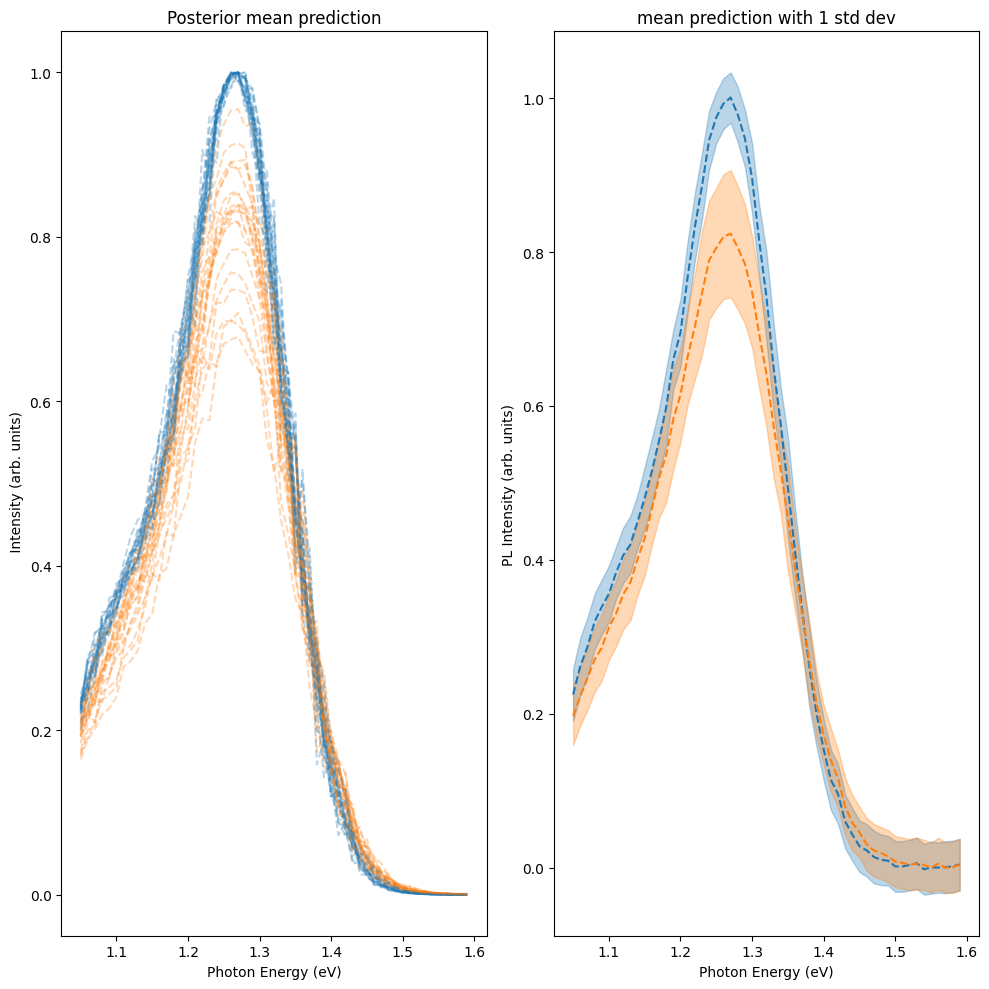

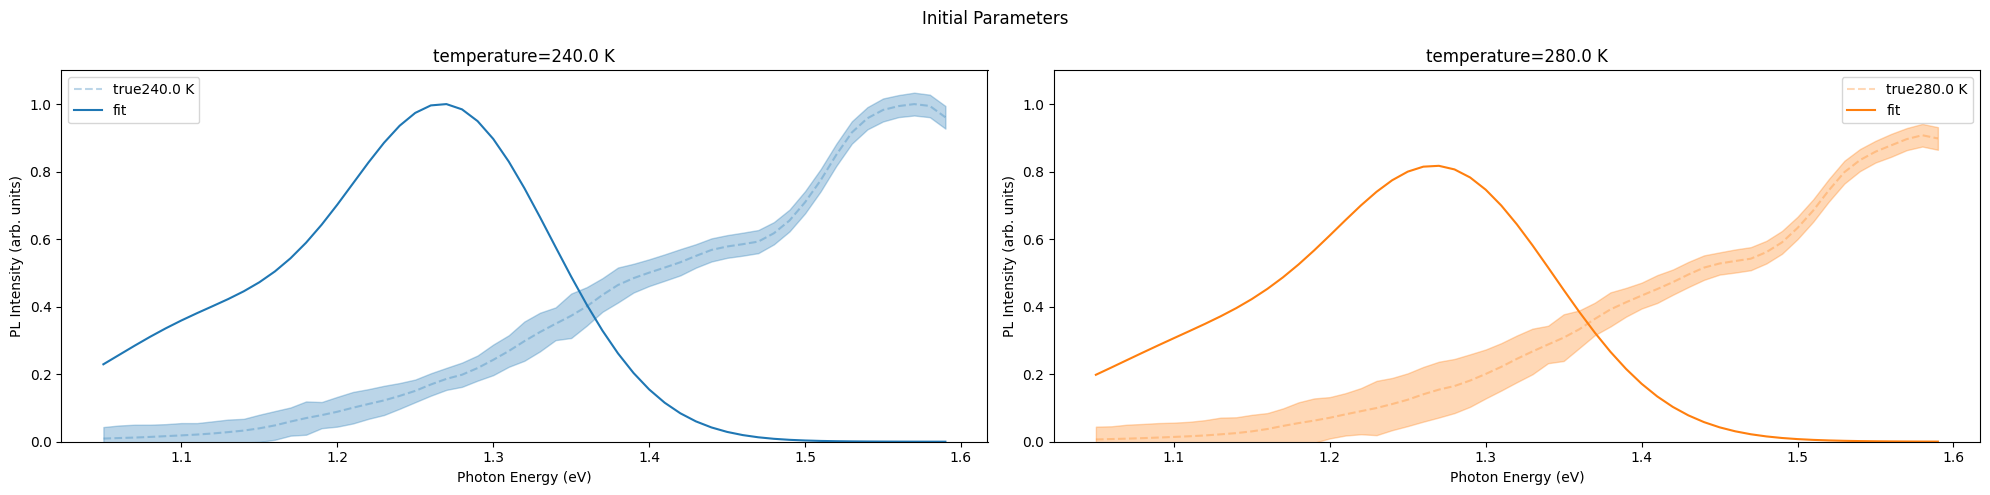

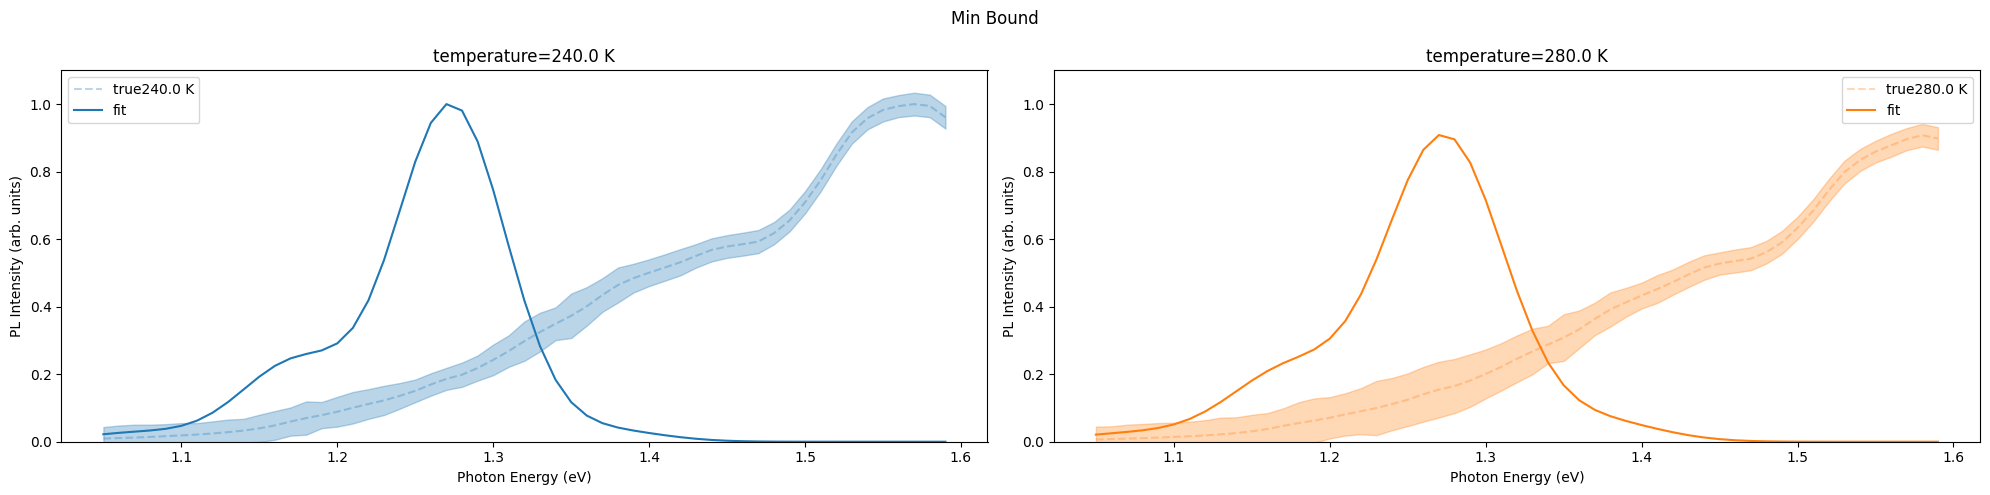

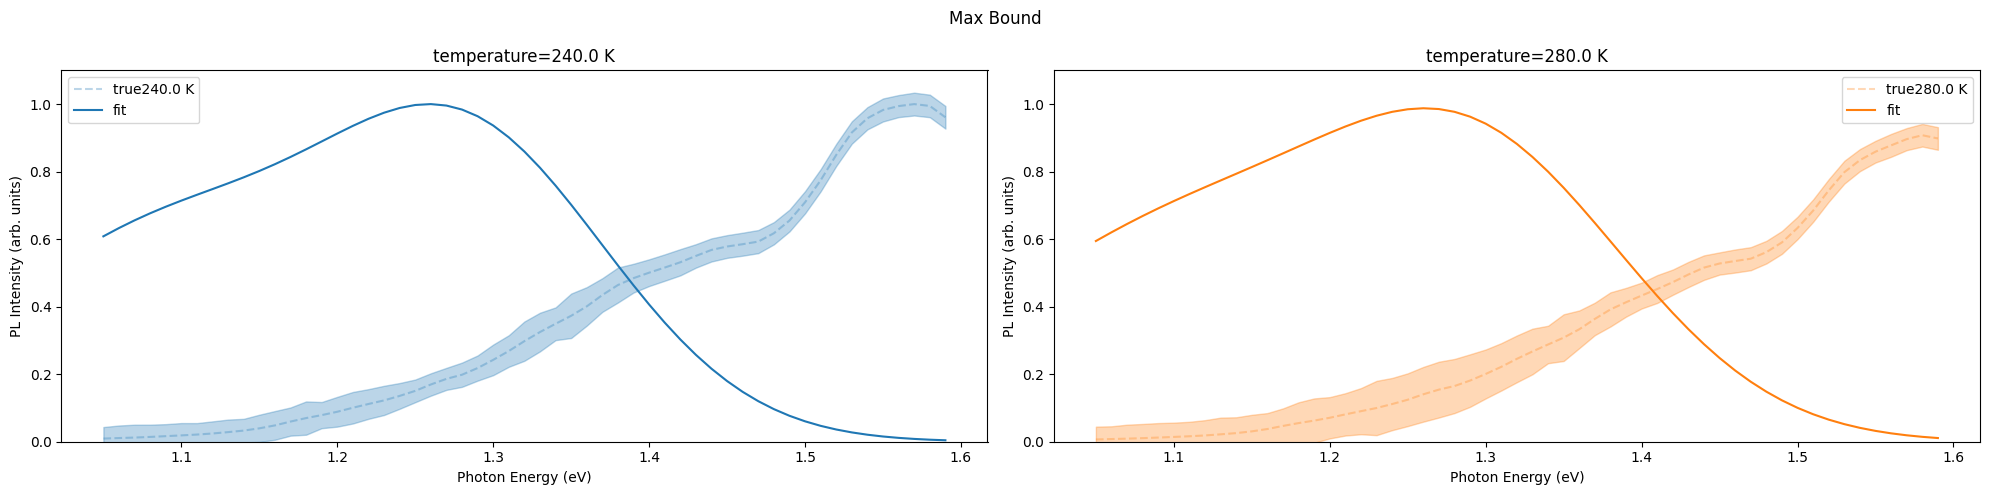

In [4]:
# plot the results with initial parameters
# and the maximum and minumum bounds
from pl_temp_fit import fit_PL_utils
import importlib

importlib.reload(fit_PL_utils)

fit_PL_utils.plot_fit_limits(model_config,model_config_save)


### run sampler in the notebook

In [5]:
import emcee
filename = model_config_save['save_folder'] + "/sampler.h5"
if os.path.exists(filename):
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    distribution = reader.get_chain(discard=0, flat=True)  
    true_parameters = fit_PL_utils.get_param_dict(model_config_save['params_to_fit_init'],distribution[-1])
else:
    true_parameters = model_config_save['params_to_fit_init']
    print('no sampler found')

no sampler found


shape of mean value plot is (55, 2)
Initial size: 5


You must install the tqdm library to use progress indicators with emcee


multi process took 61.4 seconds


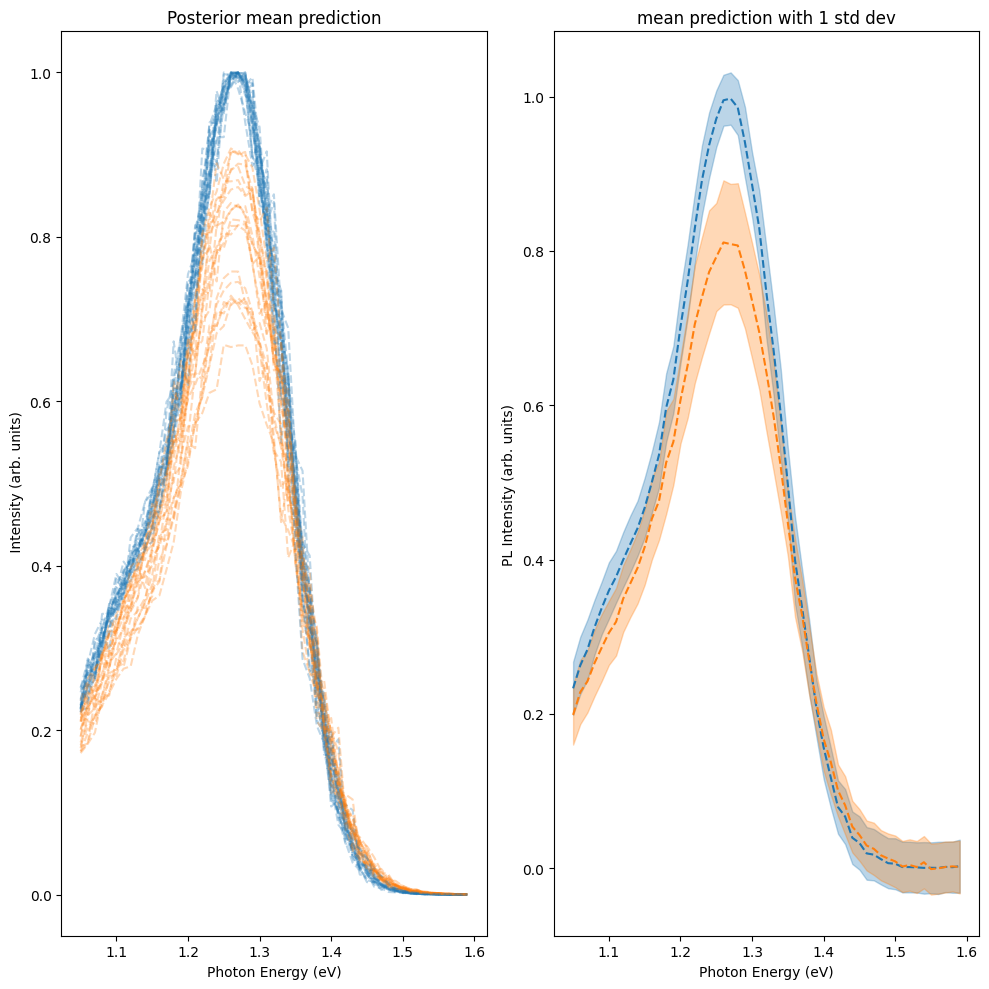

In [8]:
from pl_temp_fit import fit_PL_utils
from pl_temp_fit import fit_PL_utils, Emcee_utils
importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(fit_PL_utils)
importlib.reload(Emcee_utils)


Temp_std_err = model_config_save['Temp_std_err']
hws_std_err = model_config_save['hws_std_err']
relative_intensity_std_error_PL = model_config_save['relative_intensity_std_error_PL']
sigma = model_config_save['sigma']
save_folder = model_config_save['save_folder']
fixed_parameters_dict = model_config_save['fixed_parameters_dict']
params_to_fit_init = model_config_save['params_to_fit_init']
min_bounds = model_config_save['min_bounds']
max_bounds = model_config_save['max_bounds']
csv_name = model_config_save['csv_name_PL']
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

co_var_mat_PL, variance_PL = (
    covariance_utils.plot_generated_data_PL(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters,
    )
)

fit_PL_utils.run_sampler_parallel(
    save_folder,
    Exp_data,
    co_var_mat_PL,
    params_to_fit_init,
    fixed_parameters_dict,
    min_bounds,
    max_bounds,
    model_config,
    nsteps=5,
    coeff_spread=1,
    num_coords = 32,
    restart_sampling=False,
    num_processes=32,
)

### run sampling in the HPC


In [7]:
model_config_id = test_id
csv_name = model_config_save['csv_name_PL']
results_name = csv_name.replace('.csv','').split('/')[-1]
sh_name = f"Run_EMCEE_{results_name}.sh"
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=32:mem=80gb:avx=true \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pl_temp_fit     \n"+\
    f"python src/pl_temp_fit/scripts/run_PL_sampling.py --model_config_id {model_config_id} \n"#${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
#print(script) 
with open(f'HPC_bash_script/{sh_name}', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  
script= f"qsub  -e ./cache -o ./cache HPC_bash_script/{sh_name}"#submit to HPC
os.system(script)

FileNotFoundError: [Errno 2] No such file or directory: 'HPC_bash_script/Run_EMCEE_IDTBR_mod_split200.0_split310.sh'